<a href="https://colab.research.google.com/github/doohong91/reinforcement-learning-study/blob/main/ipynb/MountainCar_V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import gym
import collections
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Hyperparameters
learning_rate = 0.001
gamma = 0.980
buffer_limit = 100000
batch_size = 2000

In [10]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, data):
        self.buffer.append(data)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])
        
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)

In [22]:
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(2, 128) 
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()

        if coin < epsilon:
            return random.randint(0,2)
        else : 
            return out.argmax().item()

In [23]:
def train(q, q_target, memory, optimizer):
    for i in range(15):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)

        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
env = gym.make('MountainCar-v0')
q = Qnet()
q_target = Qnet()
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()

print_interval = 20
score = 0.0 
optimizer = optim.Adam(q.parameters(), lr=learning_rate)
render = False
max_position = -0.4
success = 0
count = 0
positions = np.ndarray([0,2])

for n_epi in range(800):
    epsilon = max(0.01, 0.08 - 0.01*(n_epi/100))

    s = env.reset()

    done = False

    while not done:
        a = q.sample_action(torch.from_numpy(s).float(), epsilon) 
        s_prime, r, done, info = env.step(a)
        done_mask = 0.0 if done else 1.0

        if a != 3:
            count += 1

        if s_prime[1]>0: #오른쪽으로 가는 속도에 더 큰 리워드를 받도록 한다.
            r=((s_prime[0]+0.5)*10)**2/10+15*s_prime[1]-count/400 #위치에 따라 리워드를 이차함수 형태로 가중치를 받는다.
        else:
            r = ((s_prime[0]+0.5)*10)**2/10-count/400

        if s_prime[0] > max_position:
            max_position = s_prime[0]
            positions = np.append(positions, [[n_epi, max_position]], axis=0)

        if s_prime[0] >= 0.5: #flag 위치가 0.5
            success += 1 #flag에 닿으면 성공
            r = 20 #성공하면 리워드 20을 받는다.
        else:
            score -= 1

        memory.put((s,a,r,s_prime, done_mask))
        s = s_prime

        if render:
            env.render()

        if done:
            count = 0
            max_position = -0.4
            break

        if success/print_interval*100 == 100:
            render = True

    if memory.size()>8000:
        train(q, q_target, memory, optimizer)

    if n_epi%print_interval==0 and n_epi!=0:
        q_target.load_state_dict(q.state_dict())
        print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%, success rate : {}%".format(
        n_epi, score/print_interval, memory.size(), epsilon*100, success/print_interval*100))
        score = 0.0
        success = 0

plt.figure(1, figsize=[10,5])
plt.plot(positions[:,0], positions[:,1])
plt.xlabel('Episode')
plt.ylabel('Furthest Position')

env.close()

In [98]:
# libraries
import gym
import collections
import random

# pytorch library is used for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# hyperparameters
learning_rate = 0.001
gamma = 0.98
buffer_limit = 100000        # size of replay buffer
batch_size = 128

In [99]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)    # double-ended queue
    
    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)

In [100]:
class DuelingQnet(nn.Module):
    def __init__(self, n_obs, n_act):
        super(DuelingQnet, self).__init__()
        self.fc1 = nn.Linear(n_obs, 128)
        self.fc_value = nn.Linear(128, 128)
        self.fc_adv = nn.Linear(128, 128)
        self.value = nn.Linear(128, 1)
        self.adv = nn.Linear(128, n_act)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        v = F.relu(self.fc_value(x))
        a = F.relu(self.fc_adv(x))
        v = self.value(v)
        a = self.adv(a)
        a_avg = torch.mean(a)
        q = v + a - a_avg
        return q

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()  

In [101]:
class Qnet(nn.Module):
    def __init__(self, n_obs, n_act):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(n_obs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_act)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()   

In [106]:
def train(q, q_target, memory, optimizer):
    for i in range(20):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)

        # DQN
        # max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)

        # Double DQN
        argmax_Q = q(s_prime).max(1)[1].unsqueeze(1)
        max_q_prime = q_target(s_prime).gather(1, argmax_Q)

        target = r + gamma * max_q_prime * done_mask
        
        # MSE Loss
        # loss = F.mse_loss(q_a, target)

        # Smooth L1 Loss
        loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [103]:
# reward function reference: https://github.com/shivaverma/OpenAIGym/blob/master/mountain-car/MountainCar-v0.py

def get_reward(state):

    if state[0] >= 0.5:  # Car has reached the goal
        return 10, 1
    if state[0] > -0.4:
        return (1+state[0])**2, 0
    return -1, 0

In [ ]:
env = gym.make('MountainCar-v0')

q = DuelingQnet(env.observation_space.shape[0], env.action_space.n)
q_target = DuelingQnet(env.observation_space.shape[0], env.action_space.n)
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()

print_interval = 20
score = reached = 0.0
logs = []
optimizer = optim.Adam(q.parameters(), lr=learning_rate)

for n_epi in range(3000):
    epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
    s = env.reset()
    done = False
    
    while not done:
        a = q.sample_action(torch.from_numpy(s).float(), epsilon)
        s_prime, r, done, info = env.step(a)
        done_mask = 0.0 if done else 1.0

        # r, goal = get_reward(s_prime)
        score += r
        reached += 0 if r < 0 else 1

        memory.put((s,a,r/100.0,s_prime, done_mask))
        s = s_prime
        
        if done:
            break
        
    if memory.size() > 8000:
        train(q, q_target, memory, optimizer)

    if n_epi%print_interval==0 and n_epi!=0:
        q_target.load_state_dict(q.state_dict())
        print(f"n_episode: {n_epi}, score: {score:.1f}, reached: {reached:.2f}%, n_buffer: {memory.size()}, eps: {epsilon*100:.1f}%")

    logs.append(score)
    score = reached = 0.0
    

env.close()

Text(0, 0.5, 'Return')

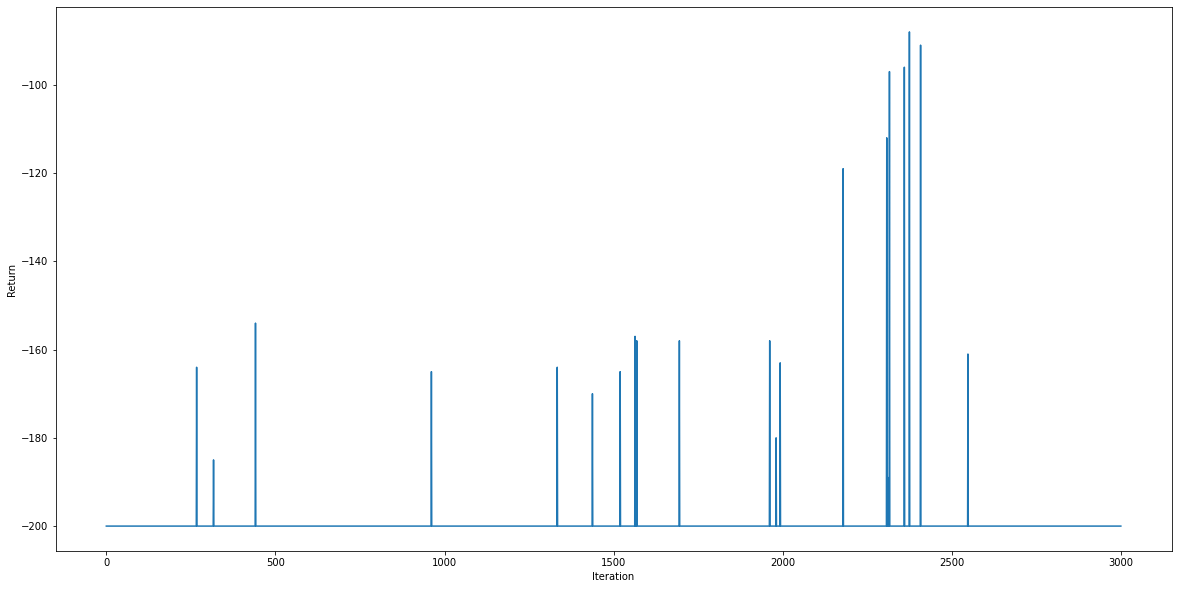

In [110]:
plt.figure(figsize=(20,10))
plt.plot(logs)
plt.xlabel('Iteration')
plt.ylabel('Return')

In [111]:
class PolicyNet(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_size=128):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_layer_size)
        self.fc2 = torch.nn.Linear(hidden_layer_size, output_size)
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, x):
        x = torch.from_numpy(x).float()
        return self.softmax(self.fc2(torch.nn.functional.relu(self.fc1(x))))

    def get_action_and_logp(self, x):
        action_prob = self.forward(x)
        m = torch.distributions.Categorical(action_prob)
        action = m.sample()
        logp = m.log_prob(action)
        return action.item(), logp

    def act(self, x):
        action, _ = self.get_action_and_logp(x)
        return action

class ValueNet(torch.nn.Module):
    def __init__(self, input_size, hidden_layer_size=128):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_layer_size)
        self.fc2 = torch.nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x = torch.from_numpy(x).float()
        return self.fc2(torch.nn.functional.relu(self.fc1(x)))



In [115]:
def policyGradient(env, max_num_steps=1000, gamma=0.98, lr=0.01,
                   num_traj=10, num_iter=200):
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    Trajectory = namedtuple('Trajectory', 'states actions rewards dones logp')

    def collect_trajectory():
        state_list = []
        action_list = []
        reward_list = []
        dones_list = []
        logp_list = []
        state = env.reset()
        done = False
        steps = 0
        while not done:
            action, logp = policy.get_action_and_logp(state)
            newstate, reward, done, _ = env.step(action)
            state_list.append(state)
            action_list.append(action)
            reward_list.append(reward)
            dones_list.append(done)
            logp_list.append(logp)
            steps += 1
            state = newstate

        traj = Trajectory(states=state_list, actions=action_list,
                          rewards=reward_list, logp=logp_list, dones=dones_list)
        return traj

    def calc_returns(rewards):
        dis_rewards = [gamma**i * r for i, r in enumerate(rewards)]
        return [sum(dis_rewards[i:]) for i in range(len(dis_rewards))]

    policy = PolicyNet(input_size, output_size)
    policy_optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    value = ValueNet(input_size)
    value_optimizer = torch.optim.Adam(value.parameters(), lr=lr)

    mean_return_list = []
    for it in range(num_iter):
        traj_list = [collect_trajectory() for _ in range(num_traj)]
        returns = [calc_returns(traj.rewards) for traj in traj_list]

        #====================================#
        # policy gradient with base function #
        #====================================#
        policy_loss_terms = [-1. * traj.logp[j] * (returns[i][j] - value(traj.states[j]))
                            for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]

        #====================================#
        # policy gradient with reward-to-go  #
        #====================================#
        #policy_loss_terms = [-1. * traj.logp[j] * (torch.Tensor([returns[i][j]]))
        #                     for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]

        #====================================#
        # policy gradient                    #
        #====================================#
        # policy_loss_terms = [-1. * traj.logp[j] * (torch.Tensor([returns[i][0]]))
        #                      for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]

        policy_loss = 1. / num_traj * torch.cat(policy_loss_terms).sum()
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        value_loss_terms = [1. / len(traj.actions) * (value(traj.states[j]) - returns[i][j])**2.
                            for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]
        value_loss = 1. / num_traj * torch.cat(value_loss_terms).sum()
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        mean_return = 1. / num_traj * sum([traj_returns[0] for traj_returns in returns])
        mean_return_list.append(mean_return)
        if it % 10 == 0:
            print('Iteration {}: Mean Return = {}'.format(it, mean_return))

    return policy, mean_return_list

In [ ]:
env = gym.make('MountainCar-v0')
agent, mean_return_list = policyGradient(env, num_iter=500, gamma=1.0)

Iteration 0: Mean Return = -200.0
Iteration 10: Mean Return = -200.0
Iteration 20: Mean Return = -200.0
Iteration 30: Mean Return = -200.0
Iteration 40: Mean Return = -200.0
Iteration 50: Mean Return = -200.0
Iteration 60: Mean Return = -200.0
Iteration 70: Mean Return = -200.0
Iteration 80: Mean Return = -200.0
Iteration 90: Mean Return = -200.0
Iteration 100: Mean Return = -200.0
Iteration 110: Mean Return = -200.0
Iteration 120: Mean Return = -200.0
Iteration 130: Mean Return = -200.0
Iteration 140: Mean Return = -200.0
Iteration 150: Mean Return = -200.0
Iteration 160: Mean Return = -200.0
Iteration 170: Mean Return = -200.0
Iteration 180: Mean Return = -200.0
Iteration 190: Mean Return = -200.0
Iteration 200: Mean Return = -200.0
Iteration 210: Mean Return = -200.0
Iteration 220: Mean Return = -200.0
Iteration 230: Mean Return = -200.0


In [ ]:
plt.figure(figsize=(20,10))
plt.plot(logs)
plt.xlabel('Iteration')
plt.ylabel('Average Return')